In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle
from torch import autograd
torch.manual_seed(123)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

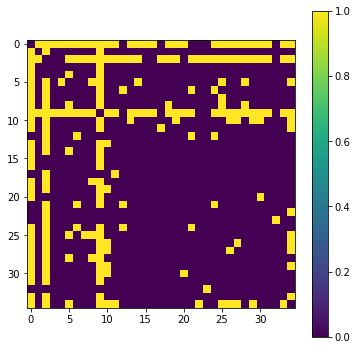

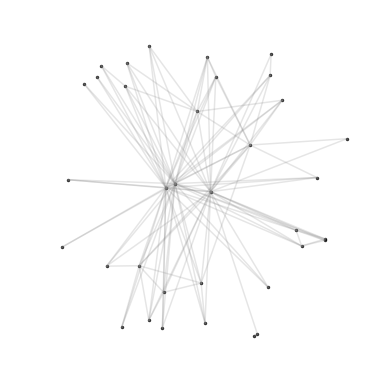

In [21]:
N = 35
R = torch.tensor([8.0]).double()
alpha = .4
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [6]:
r_init = noise_r(r, R, rel_var=0.05)
phi_init = noise_phi(theta, 0.05)

r_loc_init = logit(r_init/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = polar2cart(1, phi_init)
phi_scale_init = (torch.ones([N]).double()*30).log()

In [7]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [8]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_HRG(N,10, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [9]:
with autograd.detect_anomaly():
    vi.train(dataloader, lrs=0.1, debug=False, epochs=30)
    #vi.train(dataloader, lrs=0.01, debug=False, epochs=30)

>>>>>>>>>>>> Start training...


../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


Epoch 1 | LR: 0.10 | Total loss: 1058.69 | Epoch time 4.81
Epoch 2 | LR: 0.10 | Total loss: 650.74 | Epoch time 5.83
Epoch 3 | LR: 0.10 | Total loss: 578.68 | Epoch time 5.69
Epoch 4 | LR: 0.10 | Total loss: 567.72 | Epoch time 4.72
Epoch 5 | LR: 0.10 | Total loss: 562.37 | Epoch time 4.89
Epoch 6 | LR: 0.10 | Total loss: 544.43 | Epoch time 4.37
Epoch 7 | LR: 0.10 | Total loss: 554.11 | Epoch time 4.58
Epoch 8 | LR: 0.10 | Total loss: 520.78 | Epoch time 4.52
Epoch 9 | LR: 0.10 | Total loss: 526.22 | Epoch time 4.60
Epoch 10 | LR: 0.10 | Total loss: 517.33 | Epoch time 4.66
Epoch 11 | LR: 0.10 | Total loss: 517.07 | Epoch time 4.72
Epoch 12 | LR: 0.10 | Total loss: 512.90 | Epoch time 4.64
Epoch 13 | LR: 0.10 | Total loss: 513.45 | Epoch time 4.65
Epoch 14 | LR: 0.10 | Total loss: 502.97 | Epoch time 4.65
Epoch 15 | LR: 0.10 | Total loss: 509.18 | Epoch time 4.60
Epoch 16 | LR: 0.10 | Total loss: 502.13 | Epoch time 4.69
Epoch 17 | LR: 0.10 | Total loss: 506.05 | Epoch time 4.67
Epoch

In [10]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()
print(R_, T_, alpha_)

tensor(4.9723, dtype=torch.float64) tensor(0.5660, dtype=torch.float64) tensor(0.9373, dtype=torch.float64)


### Original

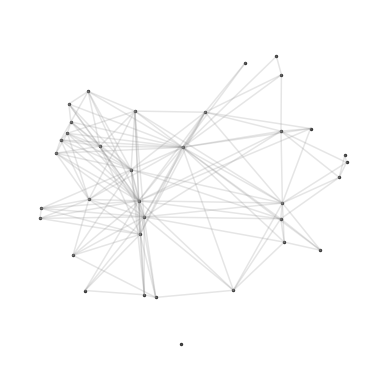

In [11]:
G.plot()

### Initialized (with noise)

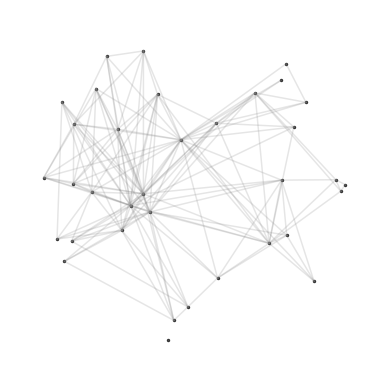

In [12]:
G_init = HRG(R=R, alpha=alpha, T=T)
G_init.r, G_init.theta, G_init.A = r_init, phi_init, A
G_init.plot()

### Estimated

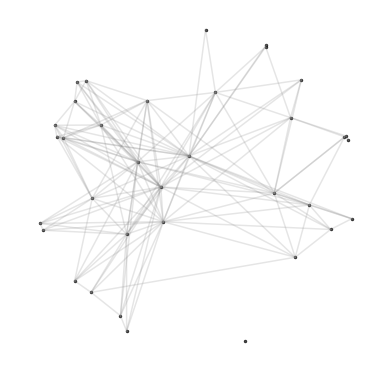

In [13]:
G_post = HRG(R=R_, alpha=alpha_, T=T_)
G_post.r, G_post.theta, G_post.A = rs_, c2d(phis_), A
G_post.plot()

In [14]:
nodes = vi.posterior_samples(100)

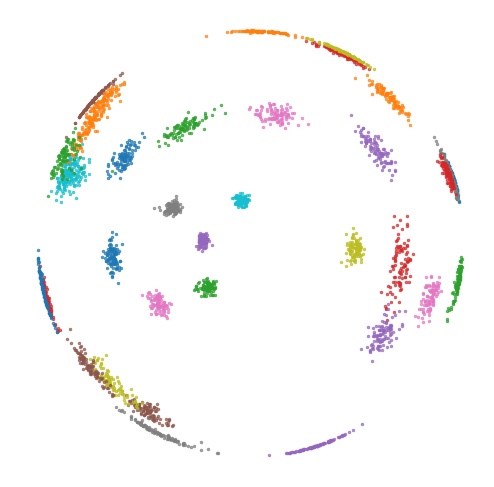

In [15]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#for link in A_.nonzero():
#    ax.plot(nodes[link,1].numpy(), nodes[link,0].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show() 

In [16]:
r_x_loc, r_x_scale, phi_x_loc, phi_x_scale, R_x_conc, R_x_scale, T_x, \
            alpha_x_conc, alpha_x_scale = vi.constrained_params()

In [17]:
phi_x_scale

tensor([256.8528, 227.9080,  75.0063, 204.5279, 175.3082, 188.8522, 150.4406,
        424.9630, 200.9639, 288.8384, 198.1557, 186.6315, 248.6447,  51.6422,
        182.9010, 280.7054, 232.6603,  84.2798, 132.1670, 483.9496, 378.1115,
        159.9634, 255.7282, 253.7668, 112.0731, 139.7857, 265.4902, 235.2614,
        181.3914, 153.0103, 117.3928, 235.7323, 259.7753, 402.2580, 116.6804],
       dtype=torch.float64, grad_fn=<ExpBackward>)

In [18]:
torch.exp(torch.tensor(0.)).expand(10)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])